In [ ]:
import math
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import pywt
import sys
import pandas as pd

# Data format:
# Raw data should be in a .txt file with two columns, separated by tabs:
#  - The first column should be a time-series index
#  - The second column should contain the data to be filtered

# Get data:
data = pd.read_csv ("NASDAQ (1).csv")
index = data.iloc[:,0].values
Data = data.iloc[:,1].values
print(index)
print(Data)

['2012/1/3' '2012/1/4' '2012/1/5' ... '2016/12/21' '2016/12/22'
 '2016/12/23']
[2648.72 2648.36 2669.86 ... 5471.43 5447.42 5462.69]


In [ ]:
# Create wavelet object and define parameters
w = pywt.Wavelet('haar')
maxlev = pywt.dwt_max_level(len(Data), w.dec_len)
maxlev= 3
print("maximum level is " + str(maxlev))
threshold = 0.04 # Threshold for filtering

# Decompose into wavelet components, to the level selected:
coeffs = pywt.wavedec(Data, 'haar', level=maxlev)


maximum level is 3


In [ ]:
datarec = pywt.waverec(coeffs, 'haar')[:-1]

In [ ]:
datarec.shape

(1255,)

In [ ]:
data = datarec

In [ ]:
wnd_size = 3
output_len=1

In [ ]:
min_data = np.min(data) #maximum over all possible IMFs and time
max_data = np.max(data)
norm_data = (data - min_data) / (max_data - min_data)

In [ ]:
data_len = data.shape[0] #total number of days of data
sample_num = data_len - wnd_size - output_len + 1  #total number of samples in the data

In [ ]:
X = np.zeros((sample_num, wnd_size + output_len))
for i in range(sample_num):
  X[i] = norm_data[i : i + wnd_size + 1]

In [ ]:
# divide the samples into training, validation and test datases as the ratio 7:2:1
train_num = int(math.floor(0.7 * sample_num))
validate_num = int(math.floor(0.2 * sample_num))
test_num = int(math.floor(0.1 * sample_num))


In [ ]:
train_X = X[: train_num, : wnd_size]
train_Y = X[: train_num, wnd_size :]

validate_X = X[train_num : train_num + validate_num, : wnd_size]
test_X = X[train_num + validate_num :, : wnd_size]

    
validate_Y = X[train_num : train_num + validate_num, wnd_size :]
test_Y = X[train_num + validate_num :, wnd_size :]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam

#A simple sequential model, to view the architecture uncomment the model.summary line
model = Sequential()
model.add(LSTM(16,input_shape=(train_X.shape[1],1)))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer="Adam", loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), tf.keras.metrics.MeanSquaredError(name="mse")])

model.summary()

history = model.fit(train_X, train_Y, epochs = 248, batch_size = 25,validation_data=(validate_X, validate_Y))

model.save('model1')
 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1152      
                                                                 
 dense_4 (Dense)             (None, 128)               2176      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dropout_5 (Dropout)         (None, 8)                

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


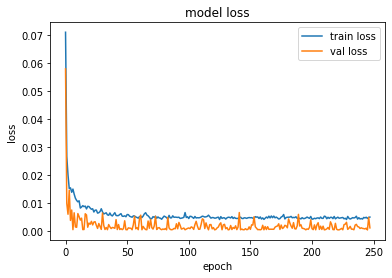

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'],loc='upper right')


plt.show()

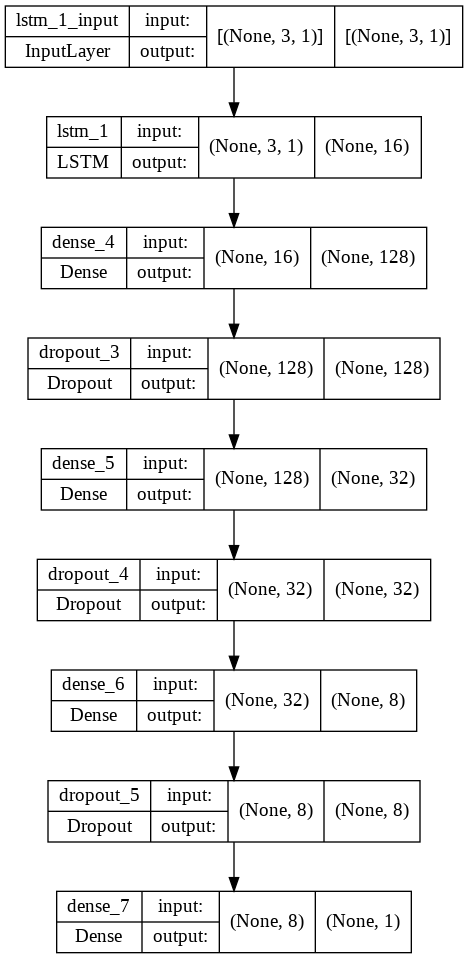

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
model = load_model('model1')
stock_predicted = model.predict(test_X)
print(f"MSE is {np.sum(np.square(stock_predicted -test_Y))/(test_Y.shape[0])}")

MSE is 0.002217707059654845


In [ ]:
test_Y_unn =  test_Y*(max_data - min_data) + (min_data)
stock_predicted_unn = model.predict(test_X)*(max_data - min_data) + (min_data)

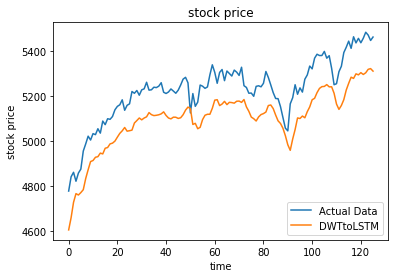

In [ ]:
plt.plot(test_Y_unn)
plt.plot(stock_predicted_unn)
plt.title('stock price')
plt.ylabel('stock price')
plt.xlabel('time')
plt.legend(['Actual Data','DWTtoNN'],loc='lower right')
plt.show()